In [1]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/rg1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rg1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rg1/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/rg1/nltk_data...


True

# Transform the data

In [3]:
# load tweets_df and view
tweets_df = pd.read_csv("Resources/Tweets.csv")
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [5]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [6]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


<AxesSubplot:ylabel='sentiment'>

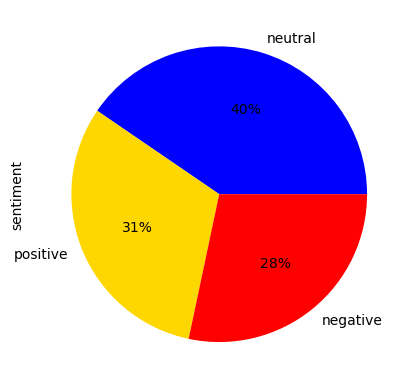

In [7]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [8]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [9]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

<AxesSubplot:ylabel='sentiment'>

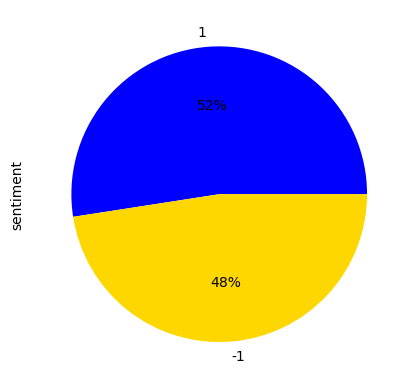

In [10]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [11]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [12]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)

In [13]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
create_model(tweets_df, 1, model, 0)
create_model(tweets_no_neut, 2, model, 0)

/Users/rg1/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Attempt 1 ----------------------------------------
Training Data Score: 0.8199902959728287
Testing Data Score: 0.6953864066365886 

[[1174  663   99]
 [ 391 2048  306]
 [  95  539 1556]]
              precision    recall  f1-score   support

          -1       0.71      0.61      0.65      1936
           0       0.63      0.75      0.68      2745
           1       0.79      0.71      0.75      2190

    accuracy                           0.70      6871
   macro avg       0.71      0.69      0.70      6871
weighted avg       0.70      0.70      0.70      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.9330997392438071
Testing Data Score: 0.8643363480811538 

[[1697  276]
 [ 279 1839]]
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      1973
           1       0.87      0.87      0.87      2118

    accuracy                           0.86      4091
   macro avg       0.86      0.86      0.86      4091
w

## Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)
create_model(tweets_df, 1, twitter_classi, train_size=.8)
create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9975891557496361
Testing Data Score: 0.7083863925777697 

[[ 935  499  116]
 [ 264 1647  307]
 [  71  346 1312]]
              precision    recall  f1-score   support

          -1       0.74      0.60      0.66      1550
           0       0.66      0.74      0.70      2218
           1       0.76      0.76      0.76      1729

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.71      5497
weighted avg       0.71      0.71      0.71      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9997708174178762
Testing Data Score: 0.8619003971891231 

[[1360  189]
 [ 263 1461]]
              precision    recall  f1-score   support

          -1       0.84      0.88      0.86      1549
           1       0.89      0.85      0.87      1724

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
w

## Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ex, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)

## Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ada, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)

# Naive Bayes

In [ ]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

from sklearn import metrics
accuracy_score = metrics.accuracy_score(y_pred, y_test)

print(accuracy_score)